In [2]:
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import pandas as pd
import plotly as plt
import plotly.express as px
import matplotlib.pyplot as mp
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation

import seaborn as sns
import featuretools as ft

p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\woodwork\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
df = pd.read_csv("./recordings/recording_matthias_2.csv", header=0)
df = df.apply(pd.to_numeric, errors="coerce")

df = df.dropna(axis=1, how="all").drop([0,1])
#df = df.loc[:, (df != df.iloc[0]).any()]
df["driver_id"] = 2

wheel_rot_vels = df[["car0_wheel0_rot_vel", "car0_wheel1_rot_vel", "car0_wheel2_rot_vel", "car0_wheel3_rot_vel"]]
df = df.drop(columns=["car0_rpm", "car0_engine_rpm", "car0_velocity_vehicle", "car0_wheel0_rot_vel", "car0_wheel1_rot_vel", "car0_wheel2_rot_vel", "car0_wheel3_rot_vel"])
df["car0_wheel_avg_rot_vel"] = wheel_rot_vels.mean(axis=1)

print(set(df.columns))

C:\Users\games\AppData\Local\Temp\ipykernel_19664\2711402285.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,23,27,31,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,71,72,73,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./recordings/recording_matthias_2.csv", header=0)


{'car0_velocity_driveline', 'car0_wheel0_skid_factor_lat', 'car0_wheel2_surface_type', 'cruiseControl{1}.mask_objects_adas', 'engine_rpm', 'timestamp', 'car0_wheel0_surface_type', 'car0_engine_torque', 'car0_engine_max_rpm', 'car0_throttle_position', 'car0_wheel2_skid_factor_lat', 'car0_wheel3_surface_volume', 'wheel_adas_velocity_K_i', 'wheel_position', 'car0{1}.shift_up', 'car0_wheel1_skid_factor_lat', 'car0_wheel3_skid_factor_lat', 'driver_id', 'car0{1}.shift_down', 'car0_turbo_pressure_normalized', 'wheel_adas_max_velocity_n_max_LW', 'car0_gear', 'car0_engine_load', 'wheel_raw_position_adas', 'wheel_adas_velocity_K_p', 'car0_velocity', 'car0_wheel3_surface_type', 'car0_turbo_spindle_rpm', 'car0_wheel1_surface_type', 'wheel_raw_torque_adas', 'car0_wheel3_skid_factor_lon', 'brakes', 'wheel_adas_max_acceleration_a_max_LW', 'car0_turbo_pressure', 'car0_wheel_avg_rot_vel', 'wheel_adas_position_K_D', 'wheel_adas_velocity_K_v_FF', 'car0_wheel1_surface_volume', 'car0_brake_position', 'car0

In [80]:
color_map = {
    "Fabian": "red",
    "Florian": "blue",
    "Matthias": "green"
}

driver_names = {
    0: "Fabian",
    1: "Florian",
    2: "Matthias"
}

df["driver_name"] = df["driver_id"].map(driver_names)


for col in df.columns:
    if col in ["driver_id", "driver_name", "timestamp"]:
        continue

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = df[col].interpolate(method='linear')

    fig = px.line(
        df,
        x="timestamp",
        y=col,
        color="driver_name",
        color_discrete_map=color_map,
        title=f"{col} über Zeit",
        labels={"timestamp": "Zeit [s]", col: col, "driver_name": "Fahrer"},
    )

    fig.update_layout(template="plotly_white")
    plt.offline.plot(fig, filename=f"./plots/matthias/2/{col}.html", auto_open=False)


In [28]:
df

,throttle,brakes,wheel_position,wheel_raw_position_adas,wheel_raw_torque_adas,car0_gear,car0_wheel0_rot_vel,car0_wheel1_rot_vel,car0_wheel2_rot_vel,car0_wheel3_rot_vel,...,car0_wheel2_skid_factor_lat,car0_wheel2_skid_factor_lon,car0_wheel2_surface_type,car0_wheel3_skid_factor_lat,car0_wheel3_skid_factor_lon,car0_wheel3_surface_type,car0_engine_torque,car0_engine_max_rpm,engine_rpm,timestamp
2,0.0,0.0,-0.000471,-2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,2.49899
3,0.0,0.0,-0.000471,-2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,2.50995
4,0.0,0.0,-0.000471,-2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,2.51992
5,0.0,0.0,-0.000471,-2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,2.53088
6,0.0,0.0,-0.000471,-2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,2.54184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112493,0.0,0.0,0.489931,2807.0,0.0,1.0,0.0,0.0,0.001672,0.000121,...,3.351910e-10,-4.149510e-09,0.0,3.708080e-10,3.829850e-09,0.0,0.000755,6250.0,799.999,1127.41000
112494,0.0,0.0,0.489931,2807.0,0.0,1.0,0.0,0.0,0.001672,0.000121,...,3.351910e-10,-4.149510e-09,0.0,3.708080e-10,3.829850e-09,0.0,0.000755,6250.0,799.999,1127.42000
112495,0.0,0.0,0.489931,2807.0,0.0,1.0,0.0,0.0,0.001672,0.000121,...,3.351910e-10,-4.149510e-09,0.0,3.708080e-10,3.829850e-09,0.0,0.000755,6250.0,799.999,1127.43000
112496,0.0,0.0,0.489931,2807.0,0.0,1.0,0.0,0.0,0.001672,0.000121,...,3.351910e-10,-4.149510e-09,0.0,3.708080e-10,3.829850e-09,0.0,0.000755,6250.0,799.999,1127.44000


<Axes: >

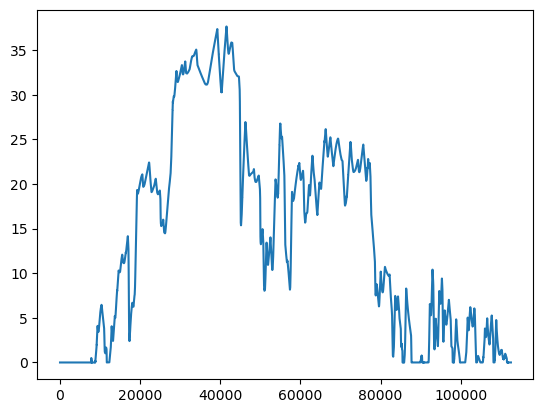

In [29]:
df['car0_velocity_vehicle'][4:].astype(float).plot()

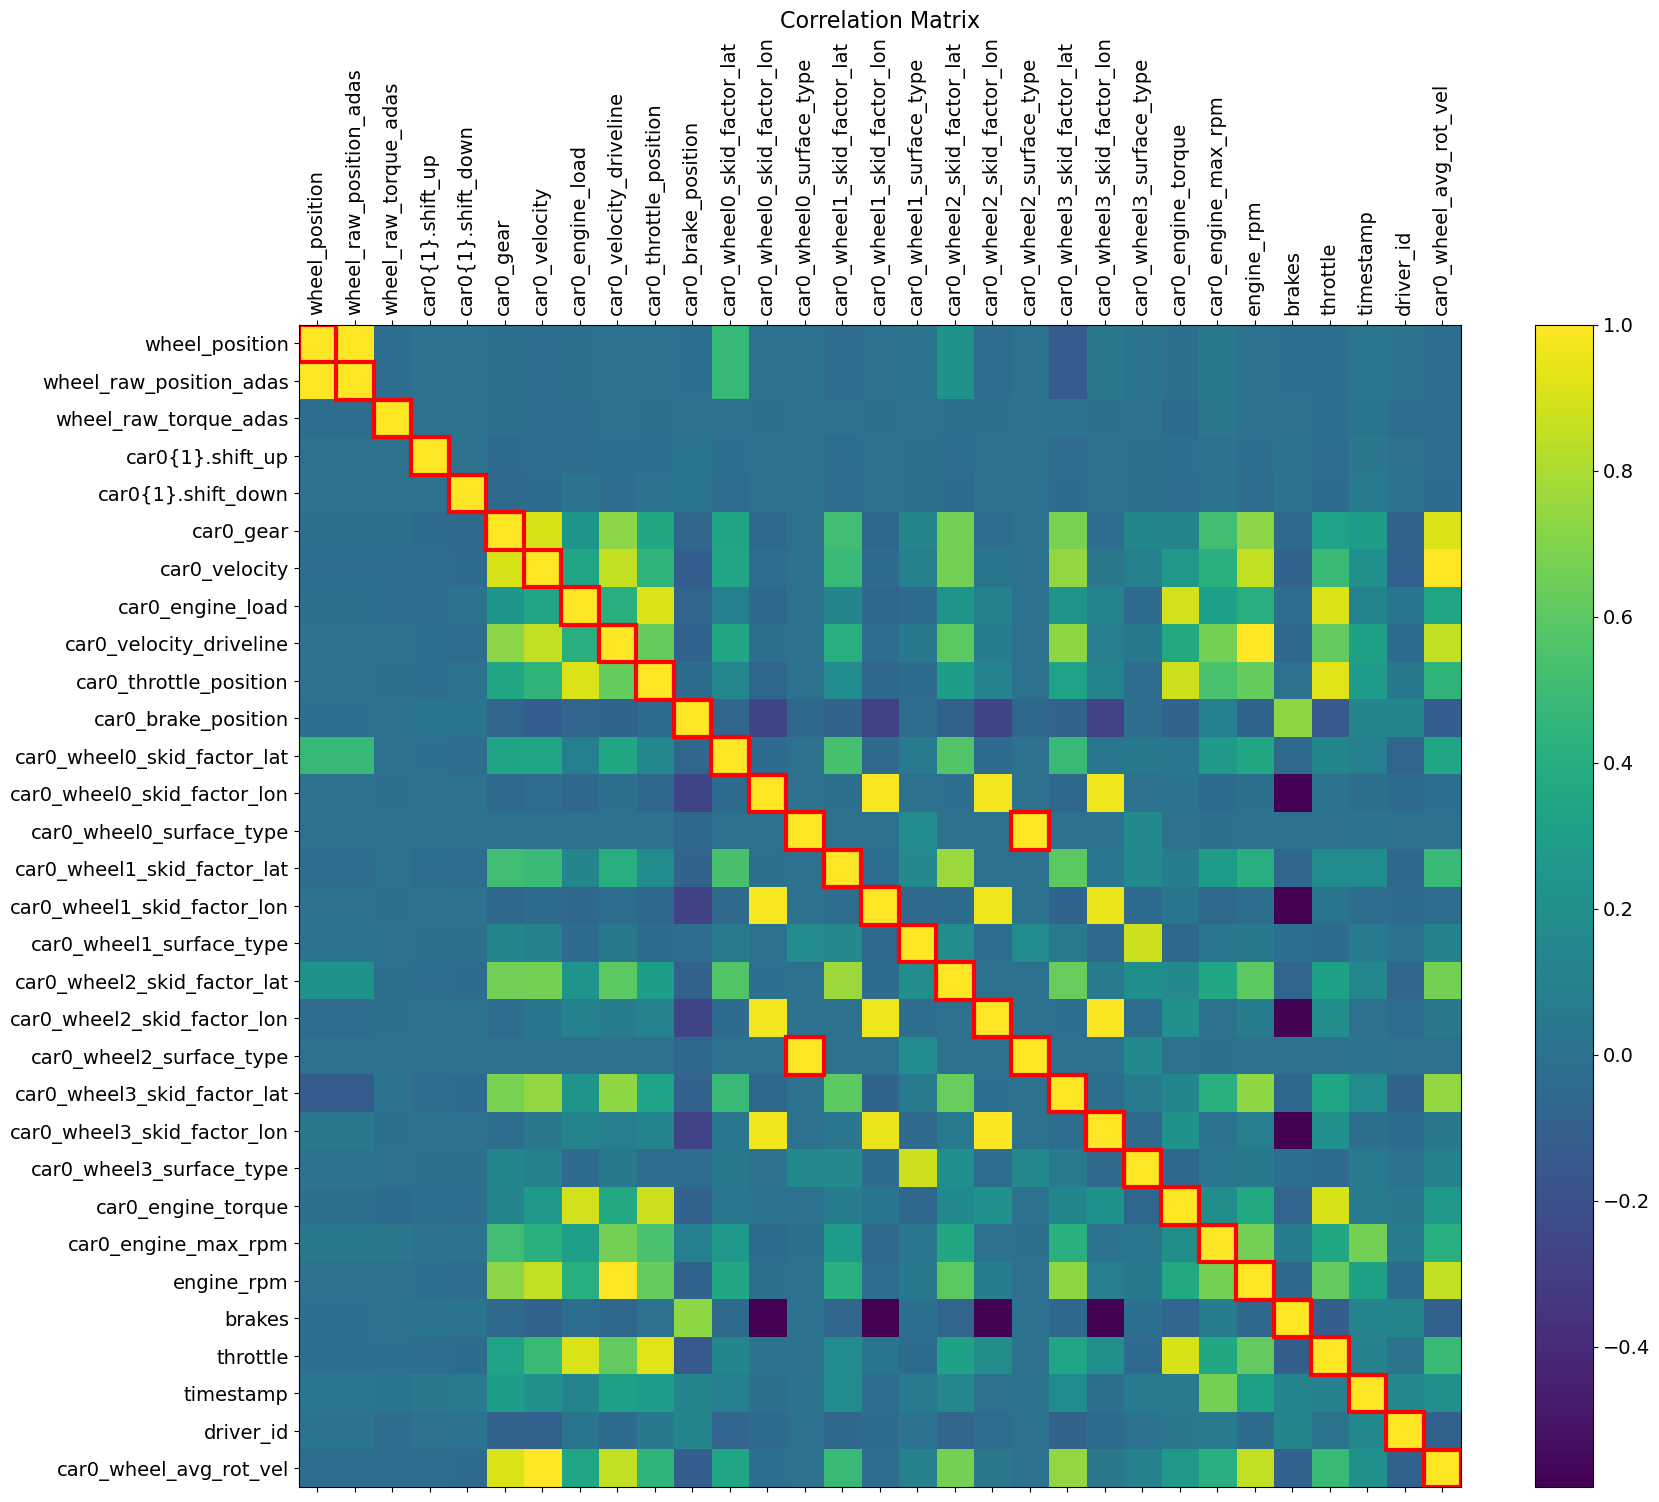

In [9]:
corr = df.corr()
num_cols = df.select_dtypes(['number']).columns
n = len(num_cols)

# Basismatrix
f = mp.figure(figsize=(19, 15))
mp.matshow(corr, fignum=f.number)
mp.xticks(range(n), num_cols, fontsize=14, rotation=90)
mp.yticks(range(n), num_cols, fontsize=14)

cb = mp.colorbar()
cb.ax.tick_params(labelsize=14)
mp.title('Correlation Matrix', fontsize=16)

# Maske für perfekte Korrelationen
mask = (corr == 1) | (corr == -1)

# Jede Zelle mit 1 / -1 markieren
for (i, j) in zip(*np.where(mask)):
    rect = mp.Rectangle((j - 0.5, i - 0.5), 1, 1,
                        fill=False, edgecolor='red', linewidth=3)
    mp.gca().add_patch(rect)

mp.show()

In [6]:
def prepareData(dataframe : pd.DataFrame, driver_id : int):
    dataframe = dataframe.apply(pd.to_numeric, errors="coerce").drop([0,1]).interpolate().dropna(axis=1, how="all")
    dataframe = dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]
    dataframe["driver_id"] = driver_id
    return dataframe

# 1. Fahrerdaten laden
driver1 = pd.read_csv("./recordings/recording_fabian_2.csv", header=0)
driver1 = prepareData(driver1, 0)


driver2 = pd.read_csv("./recordings/recording_florian_2.csv", header=0)
driver2 = prepareData(driver2, 1)

driver3 = pd.read_csv("./recordings/recording_matthias_2.csv", header=0)
driver3 = prepareData(driver3, 2)

C:\Users\games\AppData\Local\Temp\ipykernel_19664\892991514.py:8: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,18,21,25,29,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,69,70,71,72,73,78) have mixed types. Specify dtype option on import or set low_memory=False.
  driver1 = pd.read_csv("./recordings/recording_fabian_2.csv", header=0)
C:\Users\games\AppData\Local\Temp\ipykernel_19664\892991514.py:12: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,15,16,17,18,19,24,27,31,35,39,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  driver2 = pd.read_csv("./recordings/recording_florian_2.csv", header=0)
C:\Users\games\AppData\Local\Temp\ipykernel_19664\892991514.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,23,27,31,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62

In [7]:
# 2. Fahrerdaten zusammenfassen
df = pd.concat([driver1, driver2, driver3], ignore_index=True).fillna(0)

wheel_rot_vels = df[["car0_wheel0_rot_vel", "car0_wheel1_rot_vel", "car0_wheel2_rot_vel", "car0_wheel3_rot_vel"]]
df = df.drop(columns=["car0_rpm", "car0_engine_rpm", "car0_velocity_vehicle", "car0_wheel0_rot_vel", "car0_wheel1_rot_vel", "car0_wheel2_rot_vel", "car0_wheel3_rot_vel"])
df["car0_wheel_avg_rot_vel"] = wheel_rot_vels.mean(axis=1)

In [8]:
print(set(df.columns))

{'car0_velocity_driveline', 'car0_wheel0_skid_factor_lat', 'car0_wheel2_surface_type', 'engine_rpm', 'timestamp', 'car0_wheel0_surface_type', 'car0_engine_torque', 'car0_engine_max_rpm', 'car0_throttle_position', 'car0_wheel2_skid_factor_lat', 'wheel_position', 'car0{1}.shift_up', 'car0_wheel1_skid_factor_lat', 'car0_wheel3_skid_factor_lat', 'driver_id', 'car0{1}.shift_down', 'car0_gear', 'car0_engine_load', 'wheel_raw_position_adas', 'car0_velocity', 'car0_wheel3_surface_type', 'car0_wheel_avg_rot_vel', 'car0_wheel1_surface_type', 'wheel_raw_torque_adas', 'car0_wheel3_skid_factor_lon', 'brakes', 'car0_brake_position', 'car0_wheel2_skid_factor_lon', 'car0_wheel1_skid_factor_lon', 'throttle', 'car0_wheel0_skid_factor_lon'}


In [66]:
drivers = df[["driver_id"]].drop_duplicates().reset_index(drop=True)
drivers = drivers.set_index("driver_id")

df["sample_id"] = range(len(df))
df = df.set_index("sample_id")

es = ft.EntitySet(id="sim_data")

es = es.add_dataframe(
    dataframe_name="drivers",
    dataframe=drivers,
    index="driver_id"
)

es = es.add_dataframe(
    dataframe_name="samples",
    dataframe=df,
    index="sample_id",
    time_index="timestamp"
)

es = es.add_relationship(
    parent_dataframe_name="drivers",
    parent_column_name="driver_id",
    child_dataframe_name="samples",
    child_column_name="driver_id"
)

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name='drivers',
    agg_primitives=['mean', 'min', 'max', 'std'],
    max_depth=2,
    verbose=True
)
feature_matrix

p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning:

index driver_id not found in dataframe, creating new integer column

p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning:

index sample_id not found in dataframe, creating new integer column



Built 136 features
Elapsed: 00:00 | Progress: 100%|██████████


p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning:

The provided callable <function min at 0x0000015533192200> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.

p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning:

The provided callable <function max at 0x00000155331920C0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.

p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning:

The provided callable <function std at 0x0000015533192C00> is currently using SeriesGroupBy.s

,MAX(samples.brakes),MAX(samples.car0_brake_position),MAX(samples.car0_engine_load),MAX(samples.car0_engine_max_rpm),MAX(samples.car0_engine_torque),MAX(samples.car0_gear),MAX(samples.car0_indicator_left_trigger),MAX(samples.car0_indicator_right_trigger),MAX(samples.car0_mask_objects),MAX(samples.car0_mask_objects_adas),...,STD(samples.car0_wheel3_surface_type),STD(samples.car0_wheel_avg_rot_vel),STD(samples.car0{1}.shift_down),STD(samples.car0{1}.shift_up),STD(samples.engine_rpm),STD(samples.throttle),STD(samples.timestamp),STD(samples.wheel_position),STD(samples.wheel_raw_position_adas),STD(samples.wheel_raw_torque_adas)
driver_id,,,,,,,,,,,,,,,,,,,,,
0,0.2925,0.645105,1.0,0.0,180.719,4.0,1.0,1.0,2097177.0,18.0,...,0.000000,16.082573,0.034634,0.025982,764.325519,0.176353,115.381969,0.000000,0.000000,0.000000
1,1.0000,1.000000,1.0,6250.0,255.000,6.0,0.0,0.0,0.0,0.0,...,0.170674,30.195949,0.087270,0.037419,1197.290394,0.246345,273.827098,1.116244,6395.597165,1213.046348
2,0.3915,1.000000,1.0,6250.0,211.978,6.0,0.0,0.0,0.0,0.0,...,0.032917,34.000722,0.000000,0.000000,1012.529866,0.202063,324.749350,1.752055,10038.478525,1047.352888


In [58]:
# TODO Korelationen feststellen

# 3. Relevante Merkmale gruppieren

throttle = feature_matrix[["MEAN(samples.throttle)","STD(samples.throttle)"]]
brakes = feature_matrix[["MEAN(samples.brakes)","STD(samples.brakes)"]]
#gear = df[["car0{1}.shift_up", "car0{1}.shift_down"]].drop(0).interpolate()
#indicators = df[["car0_indicator_trigger", "car0_indicator_left_trigger", "car0_indicator_right_trigger"]].drop(0).interpolate()
#velocities = df[["car0_velocity", "car0_velocity_vehicle", "car0_velocity_driveline", "car0_wheel0_rot_vel", "car0_wheel1_rot_vel", "car0_wheel2_rot_vel", "car0_wheel3_rot_vel"]].drop(0).interpolate()
#engine = df[["car0_engine_rpm", "car0_engine_load", "car0_engine_torque"]].drop(0).interpolate()
#wheels = df[["car0_wheel1_skid_factor_lat","car0_wheel1_skid_factor_lon","car0_wheel2_skid_factor_lat","car0_wheel2_skid_factor_lon",
#             "car0_wheel3_skid_factor_lat","car0_wheel3_skid_factor_lon","car0_wheel0_skid_factor_lat","car0_wheel0_skid_factor_lon"]].drop(0).interpolate()

# 4. Daten skalieren und interpolieren
#scaler = StandardScaler()
#throttle_scaled
#brakes_scaled = scaler.fit_transform(pedals)
#gear_scaled = scaler.fit_transform(gear)
#indicators_scaled = scaler.fit_transform(indicators)
#velocities_scaled = scaler.fit_transform(velocities)
#engine_scaled = scaler.fit_transform(engine)
#wheels_scaled = scaler.fit_transform(wheels)



In [66]:
# 5. Gruppen clustern
dbscan = DBSCAN(eps=0.5, min_samples=3)

clusters = pd.DataFrame({
    "throttle_cluster": dbscan.fit_predict(throttle),
    "brakes_cluster": dbscan.fit_predict(brakes)
#    "gear_cluster": dbscan.fit_predict(gear_scaled),
#    "indicators_clusters": dbscan.fit_predict(indicators_scaled),
#    "velocities_clusters": dbscan.fit_predict(velocities_scaled),
#    "engine_clusters": dbscan.fit_predict(engine_scaled),
#    "wheels_clusters": dbscan.fit_predict(wheels_scaled)
})

In [67]:
# 6. Cluster in LDA schmeißen
lda = LatentDirichletAllocation(n_components=2)
topics = lda.fit_transform(clusters)

p:\Apps\Entwicklung\Software\Anaconda\envs\MSuT\Lib\site-packages\sklearn\decomposition\_lda.py:924: RuntimeWarning: invalid value encountered in scalar divide
  perword_bound = bound / word_cnt


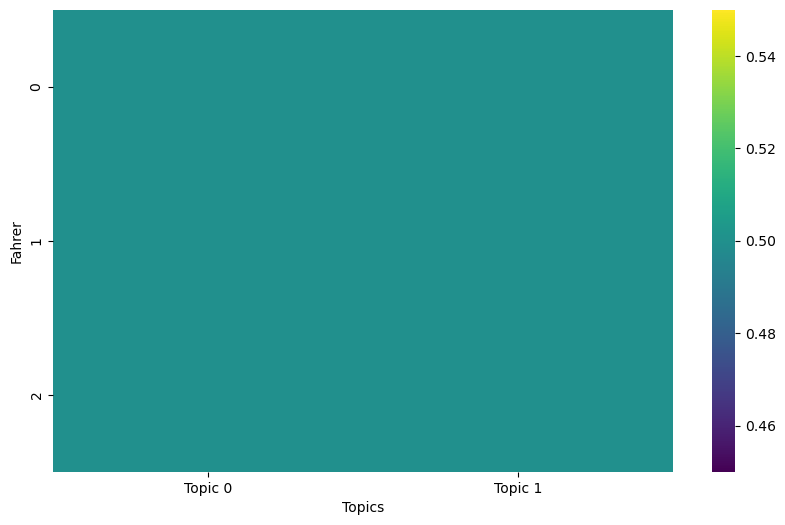

In [68]:
topics_df = pd.DataFrame(
    topics,
    columns=[f"Topic {i}" for i in range(topics.shape[1])]
)

mp.figure(figsize=(10, 6))
sns.heatmap(topics_df.head(3), cmap="viridis")
mp.xlabel("Topics")
mp.ylabel("Fahrer")
mp.show()